In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from data import get_fold_queries, create_pos_neg_pair_df, RankNetDatasetWithMap, RankNetDataset
from transformers import BertForMaskedLM, BertTokenizer
from utils import load_pickle

In [2]:

model_path = "./models/bert/Saved_model_epochs_5/"
model = BertForMaskedLM.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
base_model = model.bert
del model
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
base_model= base_model.to(device) 


In [3]:
embedding_map = load_pickle("./data/expanded_queries_embeddings.pkl")

In [4]:
for key, value in embedding_map.items():
    print(value.shape)
    break

torch.Size([8, 256])


In [5]:
def create_dataset(df, fold_number, split='train'):
    fold_queries = get_fold_queries(fold_number, split, path='./data/queries_5_fold.csv')
    fold_df = df[df["Q_name"].isin(fold_queries)]
    out_df = create_pos_neg_pair_df(fold_df, max_sample_per_query=200)
    # return RankNetDataset(out_df, tokenizer, bert=base_model, device=device)
    return RankNetDatasetWithMap(out_df, embedding_map)

In [6]:
df = pd.read_csv('./data/recall/expanded_and_labeled_queries_with_pubmed_recall_n100_200candidates.csv')
train_ds = create_dataset(df,1,'train')
val_ds = create_dataset(df,1,'test')
len(train_ds), len(val_ds)

(244382, 108880)

In [7]:
batch_size = 256

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

epoch = 10
experiment_name="pubmed_recall_ranknet_300head"

In [8]:
from ranknet import RankNet



model = RankNet(embedding_size=256, bidirectional=False, hidden_size=64, dropout_rate=0.5)

model = model.to(device)


/home/hamid/virtualenvs/uni_venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [9]:
learning_rate = 1e-5

criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [10]:
import pathlib
def save_model(model, experiment_name, file_name = 'model.pt'):

    path='./models/rnn/' + experiment_name
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), path + '/' + file_name)

def load_model(model: nn.Module, experiment_name, file_name = 'model.pt'):

    path='./models/rnn/' + experiment_name
    model.load_state_dict(torch.load(path + '/' + file_name))
    return model

def save_model_class(model, experiment_name, file_name = 'model.pt'):
    path='./models/rnn/' + experiment_name
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    torch.save(model, path + '/' + file_name)

In [11]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, ndcg_score
def evaluate(model, criterion,dataloader):
    """
    Evaluation, return accuracy and loss
    """
    total_loss = 0.0
    y_true, y_pred,y_scores = [], [], []
    data_len = len(dataloader)
    model.eval()  # set mode to evaluation to disable dropout
    with torch.no_grad():
        for x_i,x_j, y in dataloader:
            x_i,x_j, y = x_i.to(device), x_j.to(device), y.to(device)
            y_hat = model(x_i, x_j)
            y_hat = y_hat.squeeze()
            loss = criterion(y_hat.squeeze(), y.to(torch.float))
            total_loss += loss.item()
            pred =(y_hat > 1).cpu().int().tolist()

            labels = y.clone()

            y_pred.extend(pred)
            y_scores.extend(y_hat.cpu().numpy().flatten().tolist())
            y_true.extend(labels.cpu().numpy().flatten().tolist())
    
    recall = f1_score(y_true, y_pred)
    return recall, total_loss / data_len

In [12]:
from torch.autograd import Variable
from torch.nn.functional import sigmoid
total_number_of_steps = epoch * len(train_dl) 
eval_loss_steps, eval_rec_steps = [], []
train_loss_steps, train_rec_steps = [], []
best_recall = 0
best_loss = None

with tqdm(total=total_number_of_steps) as pbar:
    for _ in range(epoch):
        model.train()
        total_loss = 0.0
        y_true, y_pred = [], []
        for x_i, x_j, y in train_dl:
            x_i = x_i.to(device)
            x_j = x_j.to(device)
            optimizer.zero_grad()
            y_hat = model(x_i, x_j)
            # y_hat = sigmoid(y_hat)
            loss = criterion(y_hat.squeeze(), y.to(torch.float).to(device))
            loss.backward()
            optimizer.step()
            labels = y.clone()
            labels[y == -1] = 0 
            total_loss += loss.item()
            pred =(y_hat > 0).cpu().numpy().tolist()
            y_pred.extend(pred)
            y_true.extend(labels.cpu().numpy().tolist())
            pbar.update(1)

                
                
        
        train_recall = f1_score(y_true, y_pred)
        train_loss = total_loss / len(train_dl)
        total_loss = 0
        y_true = []
        y_pred = []
        eval_recall, eval_loss = evaluate(model,criterion, val_dl)
        if not best_loss or eval_loss < best_loss:
            save_model(model, experiment_name, 'best_eval_loss.pt')
            best_loss = eval_loss
        if eval_recall > best_recall:
            save_model(model, experiment_name, 'best_eval_recall.pt')
            best_recall = eval_recall
        eval_loss_steps.append(eval_loss)
        eval_rec_steps.append(eval_recall)
        train_loss_steps.append(train_loss)
        train_rec_steps.append(train_recall)
        pbar.set_description(f"loss: {train_loss:.4f}  f1: {train_recall:.4f}   eval loss: {eval_loss:.4f}  evall f1: {eval_recall:.4f}")

loss: 0.4613  f1: 0.7283   eval loss: 0.5713  evall f1: 0.3279: 100%|██████████| 9550/9550 [01:38<00:00, 96.67it/s] 


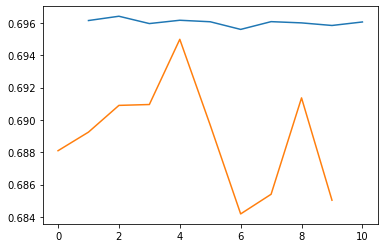

In [ ]:
import matplotlib.pyplot as plt


plt.plot(np.linspace(1, len(eval_loss_steps), len(eval_loss_steps)).astype(int), eval_loss_steps, train_loss_steps)


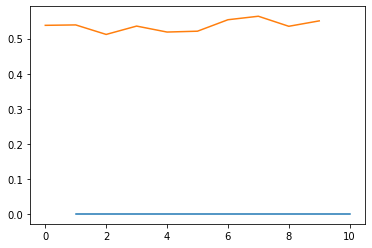

In [ ]:
plt.plot(np.linspace(1, len(eval_loss_steps), len(eval_loss_steps)).astype(int), eval_rec_steps, train_rec_steps)
